# preparations

## loading necessary libraries

In [2]:
%pip install qiskit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 76.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 78.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.5/241.5 kB 33.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 19.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 90.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.5/37.5 MB 22.7 MB/s eta 0:00:00


In [3]:
from qiskit import QuantumCircuit, QuantumRegister, execute
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, pauli_error, ReadoutError, thermal_relaxation_error, depolarizing_error
from qiskit.quantum_info import Statevector, DensityMatrix

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import time

## noise model based on IonQ's Aria specifications:
depolarizing error probability is probabilities adjusted from thermal noise infidelity: $p = e^{-t/T_2}$ with gate time for $t$

In [4]:
# error probabilities
p_meas = 3.9e-3
p_reset = 3.9e-3
p_gate1 = 6e-4
p_gate2 = 6e-3

# thermal relaxation error (nanosecond time)
T1s = np.random.choice(range(10, 100), 10, replace=False) # consider adjusting range to be more reasonable
T2 = 1e9

time_meas = np.random.choice(range(600, 700), 10, replace=False)
time_u1 = 0 # virtual gate
time_gate1 = 135e3 # u1 and u2
time_gate2 = 600e3 # 2 qubit gate

# thermal relaxation error
ther_u1  = [thermal_relaxation_error(t1 * 1e9, T2, time_u1)
              for t1 in T1s]
ther_gate1  = [thermal_relaxation_error(t1 * 1e9, T2, time_gate1)
              for t1 in T1s]
ther_gate2 = [[thermal_relaxation_error(t1a * 1e9, T2, time_gate2).expand(
             thermal_relaxation_error(t1b * 1e9, T2, time_gate2))
              for t1a in T1s]
               for t1b in T1s]

# depolarizing error
dep_reset = depolarizing_error(p_reset, 1)
dep_gate1 = depolarizing_error(p_gate1 - 1.34990888e-4, 1)
dep_gate2 = depolarizing_error(p_gate2 - 5.99820036e-4, 2)

# readout error
er_meas = ReadoutError([[1 - p_meas, p_meas], [p_meas, 1 - p_meas]])

# creating the noise model
fake_aria = NoiseModel()

for j in range(10):
    fake_aria.add_quantum_error(ther_u1[j].compose(dep_gate1), "u1", [j])
    fake_aria.add_quantum_error(ther_gate1[j].compose(dep_gate1), "u2", [j])
    fake_aria.add_quantum_error(ther_gate1[j].compose(dep_gate1), "u3", [j])
    for k in range(10):
        fake_aria.add_quantum_error(ther_gate2[j][k].compose(dep_gate2), "cx", [j, k])
fake_aria.add_all_qubit_quantum_error(dep_reset, "reset")
fake_aria.add_all_qubit_readout_error(er_meas)

## miscellaneous

In [5]:
#graph plotter
def createGraph(GraphLaplacian: list[list[int]]):
    Edges = []
    for i, row in enumerate(GraphLaplacian):
        for j, v in enumerate(row[:i]):
            if v == - 1:
                Edges.append([i, j])
    Graph = nx.Graph()
    Graph.add_edges_from(Edges)
    nx.draw_networkx(Graph)

### Grover parameter finder: this optimizes `delta` $\in (0, 1)$ so that the query complexity is minimal for a given pair of target probability and ratio, `P` and `Lambda`

In [6]:
def Chebyshev(x: float, L:  float):
    return np.cos(L * np.arccos(x)) if x <= 1 else np.cosh(L * np.arccosh(x))

def GroverParameterOptimizer(P: float, Lambda: float, N: int):
    step, L, p = pow(2, - N), 0, 0
    done = False
    while p < P:
        L += 1
        delta = step
        l = int(np.ceil(np.arccosh(1 / delta) / np.arccosh(1 / np.sqrt(1 - Lambda)))) >> 1
        while l > L:
            delta += step
            l = int(np.ceil(np.arccosh(1 / delta) / np.arccosh(1 / np.sqrt(1 - Lambda)))) >> 1
        candidate = delta
        while delta < 1:
            p_new = 1 - pow(delta * Chebyshev(Chebyshev(1 / delta, 1 / (2 * l + 1)) * np.sqrt(1 - Lambda), 2 * l + 1), 2)
            if p_new >= p:
                p = p_new
                candidate = delta
            delta += step
            l = int(np.ceil(np.arccosh(1 / delta) / np.arccosh(1 / np.sqrt(1 - Lambda)))) >> 1

    delta = candidate
    l = int(np.ceil(np.arccosh(1 / delta) / np.arccosh(1 / np.sqrt(1 - Lambda)))) >> 1
    p = 1 - pow(delta * Chebyshev(Chebyshev(1 / delta, 1 / (2 * l + 1)) * np.sqrt(1 - Lambda), 2 * l + 1), 2)

    return delta, l, p

# circuits

### custom multi-conrolled phase gate with $O (n)$ depth and no ancillas

based on [arXiv:2203.11882v2](https://arxiv.org/abs/2203.11882)

In [7]:
def P_gate(n: int, phase: float):
    QRegX = QuantumRegister(n)

    QC = QuantumCircuit(QRegX)

    for q in QRegX[1:-1]:
        QC.cx(QRegX[-1], q)

    theta = phase / 2
    for q in reversed(QRegX[1:-1]):
        QC.rz(- theta / 2, q)
        theta /= 2

    for q in reversed(QRegX[1:-1]):
        QC.cx(QRegX[-1], q)

    theta = phase / 2
    for q in reversed(QRegX[1:-1]):
        QC.rz(theta / 2, q)
        theta /= 2

    QC.rz(phase * (1 - pow(2, 2 - n)) / 2, QRegX[-1])

    QC.label = f"P_gate_{n}"

    return QC.to_gate()

def R_gate(n: int):
    QRegX = QuantumRegister(n, "q")

    QC = QuantumCircuit(QRegX)

    theta = np.pi / 2
    for q in reversed(QRegX[1:-1]):
        QC.crx(theta, q, QRegX[-1])
        theta /= 2

    QC.label = f"R_gate_{n}"

    return QC.to_gate()

def Q_gate(n: int):
    QRegX = QuantumRegister(n, "q")

    QC = QuantumCircuit(QRegX)

    if n == 2:
        QC.crx(np.pi, QRegX[0], QRegX[1])
    elif n > 2:

        for j in range(n - 2, 1, - 1):
            Rj = R_gate(j+1)
            Rj.label = f"R_{j+1}"
            QC.append(Rj, QRegX[:j+1])
            QC.crx(np.pi * pow(2, 1 - j), QRegX[0], QRegX[j])

        QC.crx(np.pi, QRegX[0], QRegX[1])

        for j in range(2, n - 1):
            QC.append(R_gate(j+1).inverse(), QRegX[:j+1])

        QC.label = f"Q_gate_{n}"

    return QC.to_gate()

def CustomMCP(n: int, phase: float):

    QRegX = QuantumRegister(n)

    QC = QuantumCircuit(QRegX)

    Pn = P_gate(n, phase)
    Pn.label = "Pn"

    Qn = Q_gate(n)
    Qn.label = "Qn"

    PnI = Pn.inverse()
    PnI.label = "PnI"

    QnI = Qn.inverse()
    QnI.label = "QnI"

    QC.h(QRegX)
    QC.x(QRegX)
    QC.append(Pn, QRegX)
    QC.cx(QRegX[-1], QRegX[0])
    QC.rz(- phase * pow(2, 2 - n), QRegX[0])
    QC.cx(QRegX[-1], QRegX[0])
    QC.rz(phase * pow(2, 2 - n), QRegX[0])
    QC.rz(phase * pow(2, 2 - n), QRegX[-1])
    QC.append(Qn, QRegX)
    QC.append(PnI, QRegX)
    QC.append(QnI, QRegX)
    QC.x(QRegX)
    QC.h(QRegX)

    return QC.to_gate()

### half of the cost oracle

In [8]:
def CostOracle(QuadraticForm: list[list[int]], y: int, digits: int):

    QRegX = QuantumRegister(len(QuadraticForm))
    QRegY = QuantumRegister(digits)

    QC = QuantumCircuit(QRegX, QRegY)

    QC.h(QRegY)

    # adding y-1-sum(Q)-trace/4 to the anicillas
    theta = np.pi * (y - 1 - QuadraticForm.sum() - np.trace(QuadraticForm)/4)
    for q in reversed(QRegY):
        QC.rz(theta, q)
        theta /= 2

    # subtracting (C(x)+sum(Q)+trace/4) from the anicillas
    for i, p in enumerate(QRegX):

        if np.sum(QuadraticForm[i]) != 0:
            # double-check this for loop for general QUBOs
            theta = - np.sum(QuadraticForm[i]) * np.pi
            for q in reversed(QRegY):
                QC.cx(q, r)
                QC.rz(- theta, p)
                QC.cx(q, r)
                QC.rz(theta, p)
                theta /= 2

        for j, r in enumerate(QRegX[i + 1:]):
            if QuadraticForm[i][i + 1 + j] != 0:
                QC.cx(p, r)
                theta = QuadraticForm[i][i + 1 + j] * np.pi / 2
                for q in reversed(QRegY):
                    QC.cx(q, r)
                    QC.rz(- theta, r)
                    QC.cx(q, r)
                    QC.rz(theta, r)
                    theta /= 2
                QC.cx(p, r)

    # Modified Inverse Quantum Fourier Transform
    for i, q in enumerate(reversed(QRegY)):
        QC.rz((pow(2, - i) - 1) * np.pi / 2, q)
        theta = np.pi / 2
        for r in QRegY[digits-i:]:
            theta /= 2
            QC.cx(r, q)
            QC.rz(theta, q)
            QC.cx(r, q)
        QC.h(q)

    return QC.to_gate()

### Grover Fixed Point Search for gerenal QUBO problems

In [9]:
def GroverForQUBO(QuadraticForm: list[list[int]], digits: int, y: int, P: float, Lambda: float, noise: bool):

    delta, l, _ = GroverParameterOptimizer(P, Lambda, 10)
    gamma = 1 / np.sqrt(1 - pow(np.cosh(np.arccosh(1 / delta) / (2 * l + 1)), - 2))
    angles = [2 * np.arctan(gamma / np.tan(2 * np.pi * j / (2 * l + 1))) for j in range(1, l + 1)]

    CostGate = CostOracle(QuadraticForm, y, digits)
    CostGateInverse = CostGate.inverse()

    # one quantum register for each vertex
    QRegX = QuantumRegister(len(QuadraticForm))

    # quantum registers to digitize y
    QRegY = QuantumRegister(digits)

    QC = QuantumCircuit(QRegX, QRegY)

    QC.h(QRegX)

    for alpha, beta in zip(angles, reversed(angles)):

        # S_t (beta)
        QC.append(CostGate, QRegX[:] + QRegY[:])
        QC.rz(beta, QRegY[0])
        QC.append(CostGateInverse, QRegX[:] + QRegY[:])

        # S_s (alpha)
        QC.append(CustomMCP(len(QuadraticForm), alpha), QRegX)

    if noise:
        QC.save_density_matrix(qubits=QRegX, label=f"rho")
        simulator = AerSimulator(method="density_matrix", noise_model=fake_aria)
        psi = execute(QC, simulator).result().data()["rho"].probabilities()
    else:
        QC.save_statevector()
        simulator = AerSimulator(method="statevector")
        psi = Statevector(execute(QC, simulator).result().get_statevector()).probabilities(np.arange(len(QRegX)))

    return psi

# parameters & testing:

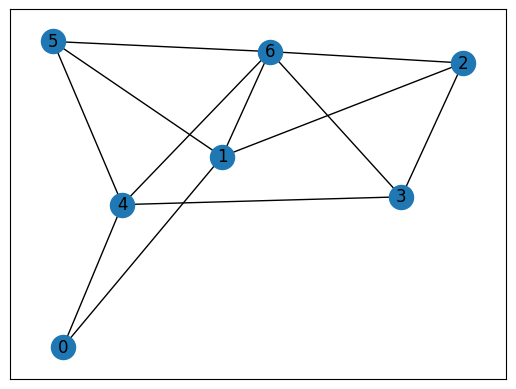

In [10]:
# graph size
NumberOfVerticies = 7 # must be <= 18 to fit in Aria
edge_probability = 5e-1

# random, connected graph
disconnected = True
while disconnected:
    GraphLaplacian = np.zeros((NumberOfVerticies, NumberOfVerticies), dtype=int)
    for i in range(NumberOfVerticies):
        for j in range(i + 1, NumberOfVerticies):
            if np.random.rand() < edge_probability:
                GraphLaplacian[i][j] = GraphLaplacian[j][i] = - 1
        GraphLaplacian[i][i] = - np.sum(GraphLaplacian[i])
    disconnected = (NumberOfVerticies != np.linalg.matrix_rank(GraphLaplacian) + 1)

NumberOfEdges = np.trace(GraphLaplacian) >> 1

# Erdos-Edwards bound for connected graphs
y = (2 * NumberOfEdges + NumberOfVerticies - 1) >> 2

digits = 1 + int(np.ceil(np.log2(max(y, NumberOfEdges + 1 - y)))) if NumberOfVerticies > 2 else 2

createGraph(GraphLaplacian)



# classical maxcut computation:
maxdeg = [0, 0]
for i in range(NumberOfVerticies):
    if GraphLaplacian[i][i] > maxdeg[1]:
        maxdeg = [i, GraphLaplacian[i][i]]

if maxdeg[0] + 1 != NumberOfVerticies:
    GraphLaplacian[[maxdeg[0], -1], :] = GraphLaplacian[[-1, maxdeg[0]], :]
    GraphLaplacian[:, [maxdeg[0], -1]] = GraphLaplacian[:, [-1, maxdeg[0]]]

Q = GraphLaplacian[np.ix_(np.arange(NumberOfVerticies - 1),np.arange(NumberOfVerticies - 1))]

MaxCut, Lambda = y, 0
for x in range(1 << (NumberOfVerticies - 1)):
    conf = np.array([(x >> i)&1 for i in range(NumberOfVerticies - 1)])
    cut = np.matmul(conf, np.matmul(Q, np.transpose(conf)))
    if cut >= y:
        Lambda += pow(2, 1 - NumberOfVerticies)
        if cut > MaxCut:
            MaxCut = cut

In [11]:
P = 0.9 # lower bound for the target probability
delta, l, P = GroverParameterOptimizer(P, Lambda, 10)
print(f"MaxCut\ty\tLambda\tdigits\tdelta\tl\tprob\n{MaxCut}\t{y}\t{round(Lambda, 2)}\t{digits}\t{round(delta, 2)}\t{l}\t{round(P, 5) * 100}%")

MaxCut	y	Lambda	digits	delta	l	prob
9	7	0.41	4	0.43	1	100.0%


### simulation:

In [15]:
noise = True
noise = False

print(f"\ncomputation with Grover Fixed Point Search...\n")
start_time = time.time()
psi = GroverForQUBO(GraphLaplacian, digits, y, P, Lambda, noise)
end_time = time.time()
print(f"done in {round(end_time - start_time, 2)} seconds\n")


computation with Grover Fixed Point Search...

done in 0.33 seconds



In [16]:
s = "simulation with noise\n" if noise else "simulation without noise\n"
s += f"\nthe graph:\n----------\nMaxCut\t\t\t= {MaxCut}\nnumber of edges\t\t= {np.trace(GraphLaplacian) >> 1}\nErdos-Edwards bound\t= {y}\n\n"
for row in GraphLaplacian:
    s += f"{row.view()}\n"
s += "\n"
s += f"Grover parameters:\n------------------\nLambda\t= {round(Lambda, 3)}\ndelta\t= {round(delta, 2)}\nl\t= {l}\n\n"
s += f"results with Grover:\n--------------------\n\n"

M = var = success = 0
distribution = {}
random_chance = {}
for i in range(MaxCut + 1):
    distribution[i] = random_chance[i] = 0

for i, p in enumerate(psi):
    conf = [(i >> j)&1 for j in range(NumberOfVerticies)]
    cut = np.matmul(conf, np.matmul(GraphLaplacian, np.transpose(conf)))
    distribution[cut] += p
    random_chance[cut] += pow(2, - NumberOfVerticies)
    M += p * cut
    var += p * cut * cut
    if cut >= y:
        success += p
var -= M*M

m, sigma = 0, 0
difference = {}
for cut in range(MaxCut + 1):
    difference[cut] = distribution[cut] - random_chance[cut]
    m += cut * random_chance[cut]
    sigma += cut * cut * random_chance[cut]

sigma -= m*m
sign_m = "+" if M >= m else "-"
sign_sigma = "+" if var >= sigma else "-"

s += f"expectation\t= {round(M, 2)}\t({m} {sign_m} {round(abs(M - m), 2)})\nvariance\t= {round(np.sqrt(var), 2)}\t({round(np.sqrt(sigma), 1)} {sign_sigma} {round(abs(np.sqrt(var) - np.sqrt(sigma)), 2)})\n\n"
s += f"success probability = {round(success * 100, 2)}% (theoretical value = {round(P, 2) * 100}%, random change = {round(Lambda, 2) * 100}%)\n"

print(s)

simulation without noise

the graph:
----------
MaxCut			= 9
number of edges		= 12
Erdos-Edwards bound	= 7

[ 2 -1  0  0 -1  0  0]
[-1  4 -1  0  0 -1 -1]
[ 0 -1  3 -1  0  0 -1]
[ 0  0 -1  3 -1  0 -1]
[-1  0  0 -1  4 -1 -1]
[ 0 -1  0  0 -1  3 -1]
[ 0 -1 -1 -1 -1 -1  5]

Grover parameters:
------------------
Lambda	= 0.406
delta	= 0.43
l	= 1

results with Grover:
--------------------

expectation	= 7.61	(6.0 + 1.61)
variance	= 0.69	(1.7 - 1.05)

success probability = 99.96% (theoretical value = 100.0%, random change = 41.0%)



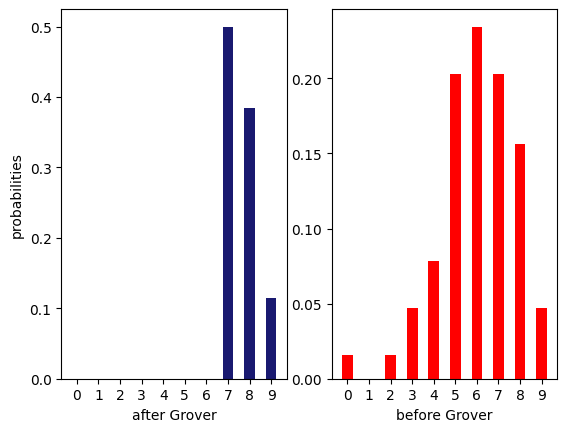

In [17]:
fig, axs = plt.subplots(1, 2)

axs[0].bar(distribution.keys(),
              distribution.values(),
              width=0.5,
              color="midnightblue",
              tick_label=[i for i in range(MaxCut + 1)])
axs[0].set(xlabel=f"after Grover", ylabel=f"probabilities")

axs[1].bar(distribution.keys(),
              random_chance.values(),
              width=0.5,
              color="red",
              tick_label=[i for i in range(MaxCut + 1)])
axs[1].set(xlabel=f"before Grover")

plt.show()

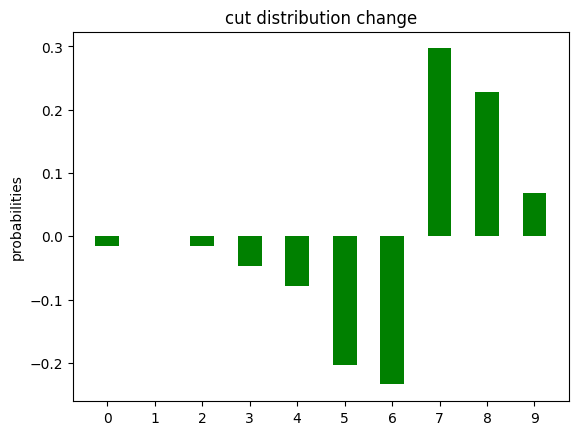

In [18]:
plt.bar(difference.keys(),
        difference.values(),
        width=0.5,
        color="green",
        tick_label=[i for i in range(MaxCut + 1)])
plt.title(f"cut distribution change")
plt.ylabel(f"probabilities")
plt.show()

## portfolio optimization